In [1]:
import uproot as ut
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from uproot3_methods import TLorentzVectorArray
import vector
import awkward as ak
from tqdm import tqdm
%matplotlib inline

import numpy as np

In [2]:
filename = "../signal/NanoAOD/NMSSM_XYH_YToHH_6b_MX_700_MY_400_accstudies_500k_May2021.root:sixBtree"
ttree = ut.open(filename)
branches_all = ttree.arrays()
nevents_all = ak.size( branches_all["Run"] )

In [6]:
total_events = 100000
branches = branches_all
nevents = ak.size( branches["Run"] )

sixb_found_mask = branches["nfound_all"] == 6
nsignal = ak.sum(sixb_found_mask)
sixb_jets = branches["signal_bjet_index"]

In [7]:
def select_jets(branches,variable="jet_ptRegressed",mask=None,jets=None,njets=6):
    if mask is None: mask = np.ones(ak.size(branches['Run']),dtype=bool)
    if jets is None: jets = branches["jet_pt"] > -999
    sorted_array = np.argsort(-branches[variable][mask])
    selected_sorted_array = jets[mask][sorted_array]
    firstN_array = np.argsort(sorted_array[selected_sorted_array]) < njets
    selected_array = sorted_array[selected_sorted_array][firstN_array]
    return selected_array

In [8]:
def count_sixb(test_selected,sixb_jets=sixb_jets,mask=None):
    nevts = ak.size(test_selected,axis=0)
    if mask is None: mask = np.ones(nevts,dtype=bool)
    sixb_jets = sixb_jets[mask]
    compare , _ = ak.broadcast_arrays( sixb_jets[:,None], test_selected)
    inter = (test_selected == compare)
    count = ak.sum(ak.flatten(inter,axis=-1),axis=-1)
    return count

In [9]:
def get_selected(branches,variable,mask=None,jets=None,sixb_jets=sixb_jets,sixb_found_mask=sixb_found_mask):
    if mask is None: mask = np.ones(ak.size(branches['Run']),dtype=bool)
    selected = select_jets(branches,variable,mask=mask,jets=jets)
    sixb_count = count_sixb(selected,sixb_jets,mask=mask)
    
    signal_selected = select_jets(branches,variable,mask=mask & sixb_found_mask,jets=jets)
    signal_sixb_count = count_sixb(signal_selected,sixb_jets,mask=mask & sixb_found_mask)
    
    return (selected,sixb_count),(signal_selected,signal_sixb_count)

In [13]:
# --- Standard Preselection --- #
def std_preselection(branches,ptcut=30,etacut=2.4,btagcut=-1):
    jet_pt_mask = branches["jet_ptRegressed"] > ptcut
    jet_eta_mask = np.abs(branches["jet_eta"]) < etacut
    jet_btag_mask = branches["jet_btag"] > btagcut
    
    jet_mask = jet_pt_mask & jet_eta_mask & jet_btag_mask
    event_mask = ak.sum(jet_mask,axis=-1) >= 6
    return event_mask,jet_mask

In [14]:
def calc_scores(branches,mask,
                selected,signal_selected,
                sixb_count,signal_sixb_count,
                sixb_jets,sixb_found_mask):
    
    mask_evnts = ak.sum(mask)
    signal_evnts= ak.sum(mask & sixb_found_mask)
    
    total_eff = mask_evnts/float(nevents)
    signal_eff = signal_evnts/float(nsignal)
    purity = signal_evnts/float(mask_evnts)

    total_score = sum( ak.sum(sixb_count == n)/float(6+1-n) for n in range(6+1))/float(mask_evnts)
    signal_score= sum( ak.sum(signal_sixb_count == n)/float(6+1-n) for n in range(6+1))/float(signal_evnts)

    return {"total_eff":total_eff,"signal_eff":signal_eff,"purity":purity,"total_score":total_score,"signal_score":signal_score}

In [15]:
ptlist = np.arange(0,101,10)
pt_valmap = {
    "total_eff":[],
    "signal_eff":[],
    "purity":[],
    "total_score":[],
    "signal_score":[]
}

for ptcut in ptlist:
    event_presel_mask, jet_presel_mask = std_preselection(branches,ptcut=ptcut)
    (preselected,sixb_count_presel),(signal_preselected,signal_sixb_count_presel) = get_selected(branches,"jet_ptRegressed",mask=event_presel_mask,
                                                                                                         jets=jet_presel_mask,sixb_jets=sixb_jets,
                                                                                                         sixb_found_mask=sixb_found_mask)
    scores = calc_scores(branches,event_presel_mask,
                         preselected,signal_preselected,
                         sixb_count_presel,signal_sixb_count_presel,
                         sixb_jets,sixb_found_mask)
    for tag,val in scores.items(): pt_valmap[tag].append(val)

In [16]:
def plot_scores(valmap,xlist):
    for tag,ylist in valmap.items():
        plt.plot(xlist,ylist,label=tag)
    plt.legend()

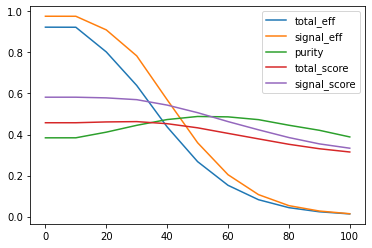

In [17]:
plot_scores(pt_valmap,ptlist)

In [21]:
btaglist = np.linspace(0,1,11)[:-1]
btag_valmap = {
    "total_eff":[],
    "signal_eff":[],
    "purity":[],
    "total_score":[],
    "signal_score":[]
}

for btagcut in btaglist:
    event_presel_mask, jet_presel_mask = std_preselection(branches,btagcut=btagcut,ptcut=10.)
    (preselected,sixb_count_presel),(signal_preselected,signal_sixb_count_presel) = get_selected(branches,"jet_btag",mask=event_presel_mask,
                                                                                                         jets=jet_presel_mask,sixb_jets=sixb_jets,
                                                                                                         sixb_found_mask=sixb_found_mask)
    scores = calc_scores(branches,event_presel_mask,
                         preselected,signal_preselected,
                         sixb_count_presel,signal_sixb_count_presel,
                         sixb_jets,sixb_found_mask)
    for tag,val in scores.items(): btag_valmap[tag].append(val)

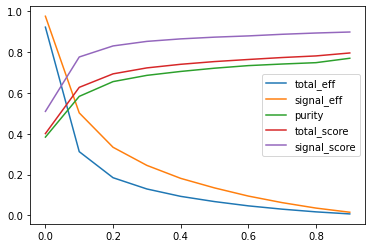

In [22]:
plot_scores(btag_valmap,btaglist)